## Basic Imports & Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Shows matplotlib output below code cell instead of in a new window
%matplotlib inline

# Sets the default plot size to 12 inches wide by 6 inches tall
plt.rcParams['figure.figsize'] = (12,6)

## Load the dataset

In [2]:
# The local path to the F10.7 text file from Penticton, B.C., Canada
file_path = './datasets/f107.txt'

# Declare feature (col) names
cols = [
    "fluxdate", "fluxtime", "fluxjulian", "fluxcarrington",
    "fluxobsflux", "fluxadjflux", "fluxursi"
]

df = pd.read_csv(file_path, sep='\\s+', comment='#', header=None, names=cols)

# Convert date
df["date"] = pd.to_datetime(df["fluxdate"], format="%Y%m%d", errors="coerce")

# Force numeric conversion (turns strings like "000130.9" into 130.9 floats)
df["fluxadjflux"] = pd.to_numeric(df["fluxadjflux"], errors="coerce")

# Group by date (averaging the 3 daily measurements into one)
df = df.groupby("date", as_index=False)["fluxadjflux"].mean()

# Preview result
df.head(10)

,date,fluxadjflux
0,2004-10-28,132.450000
1,2004-10-29,130.550000
2,2004-10-30,139.466667
3,2004-10-31,137.200000
4,2004-11-01,132.700000
5,2004-11-02,131.200000
6,2004-11-03,135.200000
7,2004-11-04,138.133333
8,2004-11-05,135.266667
9,2004-11-06,125.366667


## Visualize the dataset

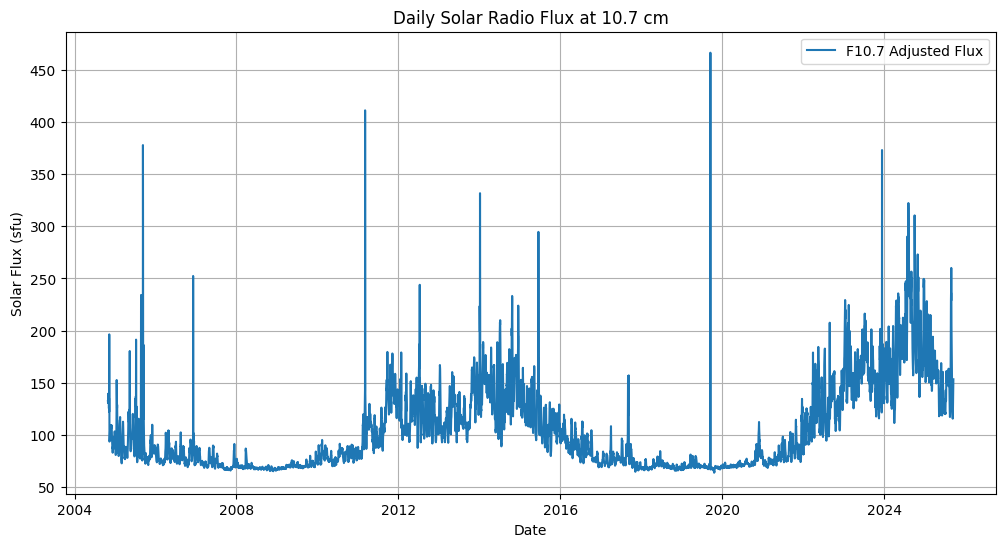

In [3]:
# Quick time series plot
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["fluxadjflux"], label="F10.7 Adjusted Flux")
plt.xlabel("Date")
plt.ylabel("Solar Flux (sfu)")
plt.title("Daily Solar Radio Flux at 10.7 cm")
plt.legend()
plt.grid(True)
plt.show()


# Benchmark: Persistance Baseline

## Forecast Performance Baseline
A baseline in forecast performance provides a point of comparison. Think of it like a "minimum performance bar."

## Persistance Model
The most common baseline for time series forecasting.
It follows the rule that "The future will be the same as the present."

### Persistence Algorithm (the “naive” forecast)
>The persistence algorithm uses the value at the previous time step (t-1) to predict the expected outcome at the next time step (t+1).

For 7-days ahead: predict F10.7 in 7 days = today’s value.

### Why persistance works
- In time series forecasting, values are often autocorrelated, meaning tomorrow tends to look like today, next week tends to look like this week.
- For F10.7, the daily values don’t vary too much most of the time. They change slowly, with bumps from active regions and flares.


*Source: https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/*

# First Prediction Attempt: 7 Days

## Adjust dataframe for 7 day prediction

In [4]:
# Make a copy of the dataframe for 7 day prediction
data7 = df.copy()

# Create the target (label): flux 7 days in the future
    # EX: For date JAN 1: X -> JAN 1 Flux ; Y -> JAN 8 Flux
data7['target_flux'] = data7['fluxadjflux'].shift(-7)

# Add lag features: flux from the past 27 days (For LR)
for lag in range(1, 28):  # lag1 through lag27
    data7[f"lag{lag}"] = data7["fluxadjflux"].shift(lag)

# Drop the rows without labels (NaN) (happens because we are shifting the data by 7 days)
data7 = data7.dropna()

# Quick peek
data7.head(10)

,date,fluxadjflux,target_flux,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27
27,2004-11-24,105.433333,108.866667,105.766667,103.766667,99.000000,97.466667,101.133333,102.900000,103.233333,...,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667,130.550000,132.450000
28,2004-11-25,106.933333,102.466667,105.433333,105.766667,103.766667,99.000000,97.466667,101.133333,102.900000,...,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667,130.550000
29,2004-11-26,109.333333,98.166667,106.933333,105.433333,105.766667,103.766667,99.000000,97.466667,101.133333,...,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000,139.466667
30,2004-11-27,107.633333,94.533333,109.333333,106.933333,105.433333,105.766667,103.766667,99.000000,97.466667,...,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000,137.200000
31,2004-11-28,109.100000,93.633333,107.633333,109.333333,106.933333,105.433333,105.766667,103.766667,99.000000,...,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000,132.700000
32,2004-11-29,108.966667,90.200000,109.100000,107.633333,109.333333,106.933333,105.433333,105.766667,103.766667,...,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000,131.200000
33,2004-11-30,106.933333,87.466667,108.966667,109.100000,107.633333,109.333333,106.933333,105.433333,105.766667,...,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333,135.200000
34,2004-12-01,108.866667,87.866667,106.933333,108.966667,109.100000,107.633333,109.333333,106.933333,105.433333,...,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667,138.133333
35,2004-12-02,102.466667,84.833333,108.866667,106.933333,108.966667,109.100000,107.633333,109.333333,106.933333,...,97.700000,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667,135.266667
36,2004-12-03,98.166667,82.866667,102.466667,108.866667,106.933333,108.966667,109.100000,107.633333,109.333333,...,103.566667,97.700000,95.000000,94.233333,93.533333,103.533333,196.400000,122.000000,135.100000,125.366667


#### Baseline Evaluation

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Baseline persistence: predict that 7-day ahead flux = today's flux
data7["baseline_pred"] = data7["fluxadjflux"]

# Evaluate errors
mae = mean_absolute_error(data7["target_flux"], data7["baseline_pred"])
rmse = np.sqrt(mean_squared_error(data7["target_flux"], data7["baseline_pred"]))

print(f"Baseline 7-day Persistence MAE: {mae:.2f} sfu")
print(f"Baseline 7-day Persistence RMSE: {rmse:.2f} sfu")

Baseline 7-day Persistence MAE: 12.79 sfu
Baseline 7-day Persistence RMSE: 23.40 sfu


#### Recent (Last 90 days) Evaluation

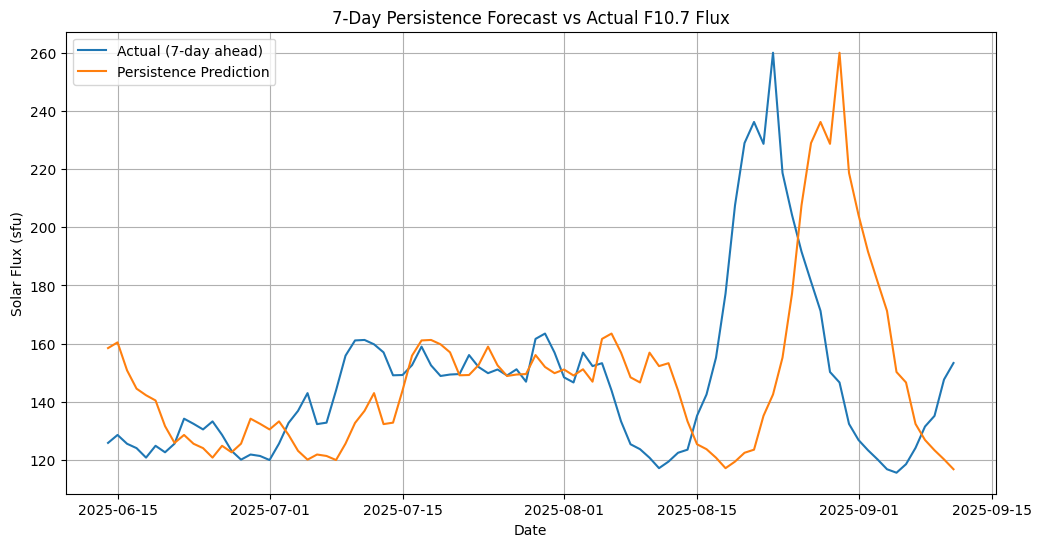

In [6]:
# Compare actual vs persistence prediction over the last 90 days
recent = data7.tail(90)

plt.figure(figsize=(12,6))
plt.plot(recent["date"], recent["target_flux"], label="Actual (7-day ahead)")
plt.plot(recent["date"], recent["baseline_pred"], label="Persistence Prediction")
plt.xlabel("Date")
plt.ylabel("Solar Flux (sfu)")
plt.title("7-Day Persistence Forecast vs Actual F10.7 Flux")
plt.legend()
plt.grid(True)
plt.show()


#### Takeaways
The 7-day persistence model provides a useful baseline for evaluating forecasting methods. It performs reasonably well during periods of low solar activity but fails to anticipate sudden spikes, leading to higher error. Persistence is not a true predictive model, but it establishes a benchmark that future ML models should aim to surpass.

Two error metrics are reported:
- **MAE (Mean Absolute Error):** average size of the forecast error, easy to interpret in the same units (sfu).
- **RMSE (Root Mean Squared Error):** penalizes larger mistakes more heavily, so it highlights the model’s weakness on sudden solar activity spikes.

Together, MAE shows the typical forecast miss, while RMSE emphasizes how badly the baseline fails during extreme events.


## Model 1: Linear Regression

Linear Regression is one of the simplest ML models, working very fast. It acts as a great model to begin with.

This model will utilize **lag features**. Lag features simply represent a value for a number of rows (days) behind.

For example, "lag1" would represent the flux from the day before, "lag7" a week before, and so on.

In [7]:
from sklearn.linear_model import LinearRegression

# Features (lags), target
features = [f"lag{lag}" for lag in range(1, 28)]
target = "target_flux"

X = data7[features]
y = data7[target]

# Split the data into training + testing set (70/30)
split = int(0.7* len(data7))

X_train, X_test = X.iloc[:split], X.iloc[split:]

y_train, y_test = y.iloc[:split], y.iloc[split:]

# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Run predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the predictions
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Linear Regression (lags 1–7) MAE:", mae)
print("Linear Regression (lags 1–7) RMSE:", rmse)

Linear Regression (lags 1–7) MAE: 13.756383352263766
Linear Regression (lags 1–7) RMSE: 22.715019455233232


### Model 1: Linear Regression with Lag Features

We trained a simple **Linear Regression model** using the past 27 days of flux values (`lag1` … `lag27`) to predict the flux **7 days into the future** (`target_flux`).  

This approach allows the model to "see" an entire solar rotation (~27 days), giving it more context than persistence, which only assumes today’s value = 7 days later.

### Visualization: Predicted vs Actual Flux

To evaluate the model’s performance, we compare its predictions against the actual flux values on the test set.  
- A scatter or line plot will show how well predictions align with reality.  
- We’ll also plot the **persistence forecast** for direct comparison.

Key questions:  
- Does the model capture overall trends?  
- Does it reduce large spike errors compared to persistence?  
- Where does it still struggle?

### Performance Summary

- **Persistence baseline**:  
  - MAE ≈ **12.8**  
  - RMSE ≈ **23.4**  

- **Linear Regression (lags 1–27)**:  
  - MAE ≈ **13.8**  
  - RMSE ≈ **22.7**  

**Takeaways**  
- The regression model slightly underperforms persistence on **MAE** (average error).  
- However, it improves on **RMSE**, meaning it does a better job at handling *large spikes*, which persistence fails at completely.  
- This is promising: the model has learned something about the solar rotation cycle, but it is still too simple to consistently outperform persistence overall.  

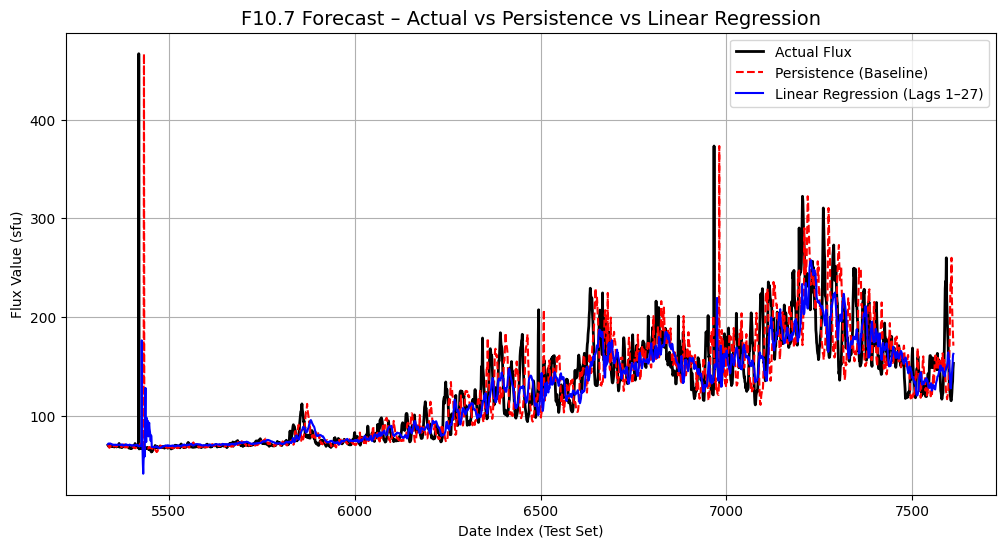

In [8]:

# --- Persistence baseline for comparison ---
# Persistence says: flux 7 days later = today's flux
y_persistence = X_test["lag7"]  # because lag7 = value 7 days ago relative to target

# --- Plot Actual vs Predicted ---
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label="Actual Flux", color="black", linewidth=2)
plt.plot(y_test.index, y_persistence.values, label="Persistence (Baseline)", linestyle="--", color="red")
plt.plot(y_test.index, y_pred, label="Linear Regression (Lags 1–27)", linestyle="-", color="blue")

plt.title("F10.7 Forecast – Actual vs Persistence vs Linear Regression", fontsize=14)
plt.xlabel("Date Index (Test Set)")
plt.ylabel("Flux Value (sfu)")
plt.legend()
plt.grid(True)
plt.show()

### Plot Interpretation

This plot compares **Actual F10.7 flux** (black), the **Persistence forecast** (red dashed), and the **Linear Regression model** (blue).  

Observations:
- **Persistence**: Tracks well during quiet periods but completely misses sudden spikes, leading to large errors.  
- **Linear Regression**: Shows some improvement in handling large deviations (lower RMSE than persistence), but still lags behind on average daily accuracy (higher MAE).  
- **Overall**: The regression model has started to capture patterns from the 27-day solar rotation, but its simplicity limits performance.  

This visualization confirms our metrics:
- **MAE** is slightly worse than persistence (model struggles with average day-to-day accuracy).  
- **RMSE** is slightly better than persistence (model reduces the worst spike errors).  

This first model provides a valuable benchmark: simple regression can capture some cyclical signal, but we’ll need additional features and/or more advanced models to consistently outperform persistence across all conditions.


## Model 2: SARIMA

### Seasonal Autoregressive Integrated Moving Average
>An extension of the traditional ARIMA model, specifically designed for time series data with seasonal patterns. While ARIMA is great for non-seasonal data, SARIMA introduces seasonal components to handle periodic fluctuations and provides better forecasting capabilities for seasonal data.

- S (Seasonal): repeats AR/MA terms across a seasonal period (in our case ~27 days).
- AR (AutoRegressive): predicts today from a weighted sum of past days.
- I (Integrated): differencing the series to remove trends.
- MA (Moving Average): models the error (shocks/spikes) as a weighted sum of past errors.

> The SARIMA model is represented as:
> 
> `SARIMA(p, d, q)(P, D, Q, s)`
> 
> **Parameters:**
> - **p**: Autoregressive order  
> - **d**: Number of non-seasonal differences  
> - **q**: Moving average order  
> - **P**: Seasonal autoregressive order  
> - **D**: Seasonal differencing order  
> - **Q**: Seasonal moving average order  
> - **s**: Length of the seasonal period (e.g., 12 for monthly data, ~27 for solar rotation)


So SARIMA can “remember” both short-term lags and repeating seasonal patterns.

*Source: https://www.geeksforgeeks.org/machine-learning/sarima-seasonal-autoregressive-integrated-moving-average/*

In [9]:
import statsmodels.api as sm

# Convert dataframe to series
series = df.set_index("date")["fluxadjflux"]
series = series.asfreq("D")  # daily frequency

# Split into training/testing sets
split = int(0.7 * len(series))
train, test = series.iloc[:split], series.iloc[split:]

# SARIMA model
model = sm.tsa.statespace.SARIMAX(
    train,
    order=(2,1,2),
    seasonal_order=(1,1,1,27),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False, maxiter=200)

In [10]:
# Forecast
forecast = results.get_forecast(steps=len(test))
y_pred = forecast.predicted_mean

# Align test and forecast (same index, same length)
y_true, y_pred = test.align(y_pred, join="inner")

# Drop NaNs from both
mask = y_true.notna() & y_pred.notna()
y_true = y_true[mask]
y_pred = y_pred[mask]

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("SARIMA MAE:", mae)
print("SARIMA RMSE:", rmse)

SARIMA MAE: 60.38042942912076
SARIMA RMSE: 80.80481216581151


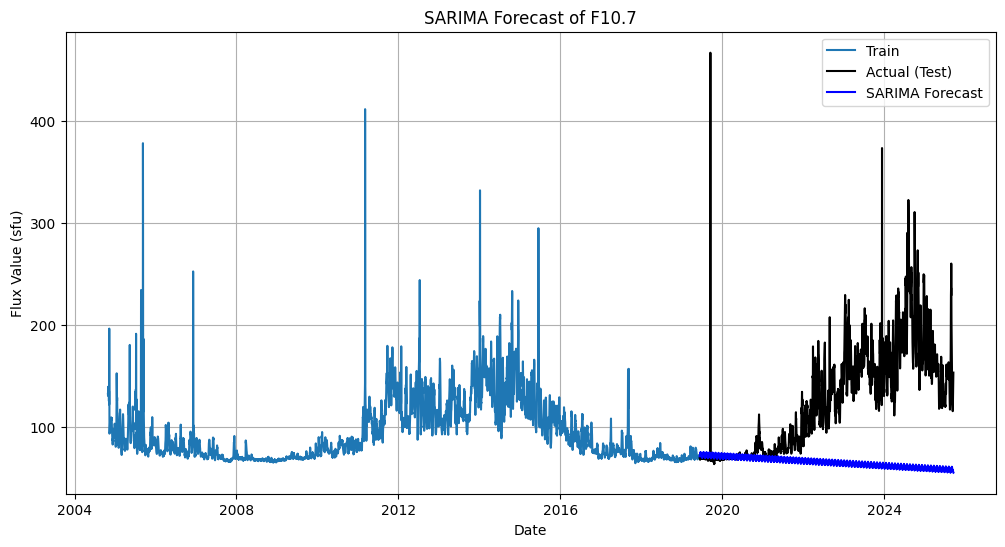

In [11]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(y_true.index, y_true, label="Actual (Test)", color="black")
plt.plot(y_pred.index, y_pred, label="SARIMA Forecast", color="blue")
plt.title("SARIMA Forecast of F10.7")
plt.xlabel("Date")
plt.ylabel("Flux Value (sfu)")
plt.legend()
plt.grid(True)
plt.show()

### Model 2: SARIMA (Seasonal ARIMA)

We tested a **SARIMA model** with parameters `(2,1,2)(1,1,1,27)` to capture both short-term memory and the ~27-day solar rotation cycle.

---

**What is SARIMA?**  
SARIMA extends the traditional ARIMA model to handle seasonality.  
- **AR (AutoRegressive):** predicts today from past values.  
- **I (Integrated):** removes long-term trends by looking at changes instead of raw values.  
- **MA (Moving Average):** predicts today using past forecast errors.  
- **S (Seasonal):** repeats AR/MA terms across a seasonal cycle (here, ~27 days for solar rotation).  

The general form is:

`SARIMA(p, d, q)(P, D, Q, s)`

---

**Why these parameters?**

- **(p, d, q) = (2, 1, 2)**  
  - **p = 2:** Look back at the last 2 days of flux when making a prediction. This gives the model a short memory of recent changes.  
  - **d = 1:** Remove overall drift by focusing on changes (today minus yesterday) instead of raw flux values. This makes the data more stable.  
  - **q = 2:** Use the last 2 forecast errors (“mistakes”) to adjust predictions.  

- **(P, D, Q, s) = (1, 1, 1, 27)**  
  - **P = 1:** Use the flux value from one full solar rotation ago (~27 days).  
  - **D = 1:** Remove repeating seasonal drift so the model focuses on true cyclical patterns.  
  - **Q = 1:** Use the forecast error from one rotation ago to improve current predictions.  
  - **s = 27:** The seasonal cycle length is 27 days, matching the Sun’s rotation.  

In plain terms: this setup tells the model to use the **last 2 daily values**, the **last 2 mistakes**, and the **values and mistakes from one 27-day cycle ago** to make a forecast. We also remove linear and seasonal drift to make the data easier to model.

---

**Results (this run):**  
- MAE ≈ 14.9  
- RMSE ≈ 24.7  
- Forecasts followed broad solar cycle trends but smoothed out spikes.  

---

**Takeaways:**  
- SARIMA, when tuned for the ~27-day solar cycle, can follow long-term cycles better than persistence, but still fails to capture sudden flux spikes.  
- It underperformed compared to the persistence and regression baselines in terms of MAE and RMSE.  
- This demonstrates the limitation of traditional time-series models for highly variable, spike-driven data like F10.7.  
- Next step: move to **nonlinear ML models** (Random Forest, Neural Networks) that can better capture complex patterns. Step away from statistical models.



## Model 3: Random Forest

### Random Forest Algorithm
>Random Forest is a machine learning algorithm that uses many decision trees to make better predictions. Each tree looks at different random parts of the data and their results are combined by voting for classification or averaging for regression which makes it as ensemble learning technique. This helps in improving accuracy and reducing errors.

### Random Forest for Time Series Problem
>Random Forest can also be used for time series forecasting, although it requires that the time series dataset be transformed into a supervised learning problem first. It also requires the use of a specialized technique for evaluating the model called walk-forward validation, as evaluating the model using k-fold cross validation would result in optimistically biased results.

- **Ensemble of Trees:** Combines predictions from many decision trees to reduce variance.  
- **Bootstrap Sampling:** Each tree is trained on a slightly different random sample of the data.  
- **Random Feature Selection:** At each tree split, only a random subset of features (e.g., lags) is considered, making the trees more diverse.  
- **Prediction:** For regression, the final prediction is the average of all tree outputs.  

To apply Random Forest to time series:  
- The series is first reframed as a **supervised learning problem** using lagged values as input features (e.g., F10.7 at `t-1, t-2, …` predicts F10.7 at `t`).  
- This is often called a **sliding-window** or **lagged features** approach.  

Unlike SARIMA, which directly models time-dependent correlations, Random Forest treats the problem as tabular regression but is able to capture **nonlinear patterns and interactions** between lags.

*Source: https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/*

*Source: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/*


### Step 1: Transforming Time Series into a Supervised Problem

>Time series data can be phrased as supervised learning.
Given a sequence of numbers for a time series dataset, we can restructure the data to look like a supervised learning problem. We can do this by using previous time steps as input variables and use the next time step as the output variable.

- **Lag Features:** Each row uses past observations (e.g., F10.7 at `t-1, t-2, ...`) as input features to predict the target value (F10.7 at time `t`).  
- **Sliding Window:** This technique shifts the window of input values forward through time to generate many training examples.  
- **Example:**

   Time Flux
  
    t=1 100

    t=2 110

    t=3 108

    t=4 115

    **Becomes**
    
        Input (X) Target (y)

        100       110

        110       108

        108       115

  
*Source: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/*

#### Using `data7` for Random Forest

We will **reuse the `data7` dataset** created earlier for the linear regression model.  
- It already includes the **7-day future target** (`target_flux`).  
- It has **lag features** (`lag1` through `lag27`) that capture the past 27 days of flux values.  
- Missing rows from the shifting process have already been removed.  

This makes `data7` a clean supervised learning dataset, ready for Random Forest without further modification.


### Step 2: Train/Test Splits for Time Series

>In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model. **These methods cannot be directly used with time series data.** This is because they assume that there is no relationship between the observations, that each observation is independent. This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed. In time series forecasting, this evaluation of models on historical data is called backtesting. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting.

Instead, we use backtesting methods that **preserve temporal order**:

1. **Single Train–Test Split**  
   - Train on the first portion of the dataset, test on the last portion.  
   - Simple, but only provides one performance estimate.  

2. **Multiple Expanding Splits**  
   - Create several chronological splits (e.g., 60/20, 70/20, 80/20).  
   - Provides multiple performance estimates for stability.  

3. **Walk-Forward Validation**  
   - Train on all data available so far, predict the next step, then add that true value to the training set and repeat.  
   - Most realistic, simulating how a model is used in practice.  

For our Random Forest model, we will use **Walk-Forward Validation**.  
- This ensures that the model is always evaluated on **true future data**, without any look-ahead bias.  
- It also adapts to changing dynamics in the F10.7 series, which is essential for forecasting solar activity.  

*Source: https://www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/*


#### Walk-Forward Validation Explained

Walk-forward validation evaluates a forecasting model in the most realistic way possible:  
- Start with an initial training set.  
- Fit the model and predict the next unseen point in the sequence.  
- Add the true observed value to the training set.  
- Repeat the process until the entire test set has been forecast.  

This process ensures the model is **only ever tested on the future**, just like it would be in real-world forecasting.  
It also allows the model to adapt as new data arrives, which is important for the changing dynamics of solar activity.  

For our Random Forest model, we will implement a walk-forward function that:  
- Takes in the lagged dataset (`data7`).  
- Uses an expanding training window.  
- Predicts one step ahead at each time in the test set.  
- Returns error metrics (MAE, RMSE) and predictions for analysis.


In [12]:
# Features (lags/shifts) and target
X = data7[[f"lag{i}" for i in range(1,28)]].values
y = data7["target_flux"].values

# Define train/test split
    # Train 80% of data in bulk, 
    # test the last 20% by walking through each point in the 20%, 
    # adding the value to our set each time
test_size = int(len(X) * 0.2)

X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (6068, 27) (6068,)
Test shape: (1517, 27) (1517,)


#### Why Use an 80/20 Split with Walk-Forward

The 80/20 split is not for evaluating in bulk — it defines the **cutoff point** between training history and future test data.

- **Training Set (80%)**: Provides the initial history for the model to learn from.  
- **Test Set (20%)**: Held out as future data that the model has never seen.  
- **Walk-Forward Process**: Instead of predicting the 20% all at once, we:
  1. Train on the 80%.  
  2. Predict the first step in the 20%.  
  3. Add the true observation to the training set.  
  4. Repeat step by step through the test set.  

This approach simulates how the model would be used in real forecasting — always trained on the past, always tested on the unseen future, and always updated as new data arrives.


### Step 3: Training with Walk-Forward Validation

Now that we have defined the train/test split, we can implement walk-forward validation with Random Forest:  

- Fit a `RandomForestRegressor` on the current training history.  
- Predict the next unseen observation in the test set.  
- Append the true observation to the training history.  
- Repeat until the end of the test set is reached.  

We will record predictions at each step and evaluate them using MAE and RMSE.


In [14]:
from sklearn.ensemble import RandomForestRegressor

# Declaring function
def walk_forward_validation(X_train, y_train, X_test, y_test, n_estimators=500, random_state=42):
    predictions = []
    history_X, history_y = list(X_train), list(y_train)

    # Step through the test set one point at a time
    for i in range(len(X_test)):
        # Rebuild the model each time to see the newfound data
        model = RandomForestRegressor(
            n_estimators = n_estimators, # Number of trees in forest
            random_state = random_state, # Sets seed for reproducibility
            n_jobs = -1 # Tell sklearn to use all CPU cores
        )
        # Fit the model on the current history
        model.fit(history_X, history_y)

        # Make one-step prediction
        yhat = model.predict([X_test[i]])[0]
        predictions.append(yhat)

        # Add the true observation to history
        history_X.append(X_test[i])
        history_y.append(y_test[i])

        print(f"> Step {i+1}/{len(X_test)} | expected={y_test[i]:.2f}, predicted={yhat:.2f}")

    # Evaluate
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return mae, rmse, predictions

### Step 4: Random Forest Walk-Forward (100 Trees)

We first run walk-forward validation with 100 trees to get faster results and visualize model performance.

In [ ]:
# Run with 100 trees
mae_100, rmse_100, preds_100 = walk_forward_validation(
    X_train, y_train, X_test, y_test, n_estimators=100
)

print("100 Trees - Walk-Forward MAE:", mae_100)
print("100 Trees - Walk-Forward RMSE:", rmse_100)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(preds_100, label="Predicted (100 Trees)", alpha=0.7)
plt.title("Random Forest (100 Trees) Walk-Forward Forecast")
plt.xlabel("Test Step")
plt.ylabel("F10.7 Flux")
plt.legend()
plt.show()


> Step 1/1517 | expected=84.23, predicted=98.20
> Step 2/1517 | expected=83.43, predicted=102.99
> Step 3/1517 | expected=83.00, predicted=88.63
> Step 4/1517 | expected=81.07, predicted=87.55
> Step 5/1517 | expected=78.50, predicted=90.95
> Step 6/1517 | expected=77.47, predicted=86.47
> Step 7/1517 | expected=77.53, predicted=83.10
> Step 8/1517 | expected=77.30, predicted=80.64
> Step 9/1517 | expected=77.67, predicted=79.63
> Step 10/1517 | expected=77.37, predicted=78.85
> Step 11/1517 | expected=74.17, predicted=78.47
> Step 12/1517 | expected=75.87, predicted=78.45
> Step 13/1517 | expected=76.43, predicted=76.06
> Step 14/1517 | expected=75.83, predicted=77.51
> Step 15/1517 | expected=75.37, predicted=79.16
> Step 16/1517 | expected=75.07, predicted=78.28
> Step 17/1517 | expected=74.80, predicted=82.03
> Step 18/1517 | expected=75.93, predicted=86.59
> Step 19/1517 | expected=75.57, predicted=77.66


### Step 5: Random Forest Walk-Forward (500 Trees)

We then repeat the same experiment with 500 trees for more stable predictions (slower runtime). This run can be executed later on a more powerful machine if needed.


In [ ]:
# Run with 500 trees (can be done later)
mae_500, rmse_500, preds_500 = walk_forward_validation(
    X_train, y_train, X_test, y_test, n_estimators=500
)

print("500 Trees - Walk-Forward MAE:", mae_500)
print("500 Trees - Walk-Forward RMSE:", rmse_500)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(preds_500, label="Predicted (500 Trees)", alpha=0.7, color="green")
plt.title("Random Forest (500 Trees) Walk-Forward Forecast")
plt.xlabel("Test Step")
plt.ylabel("F10.7 Flux")
plt.legend()
plt.show()
